# Klasifikasi Sinyal Detak Jantung (Binary Classification)


In [1]:
%pip install -q numpy pandas matplotlib seaborn scipy scikit-learn tensorflow

^C


Note: you may need to restart the kernel to use updated packages.


## 1. Business Understanding (Pemahaman Bisnis)

Tujuan Proyek: Tujuan utama dari proyek ini adalah untuk membangun model machine learning yang mampu mengklasifikasikan sinyal suara detak jantung menjadi dua kategori: Normal (sehat) dan Abnormal (memiliki patologi jantung seperti cacat katup atau penyakit arteri koroner).

Manfaat:

- Membantu tenaga medis dalam diagnosis awal penyakit jantung secara non-invasif.

- Mengurangi kesalahan manusia dalam auskultasi (mendengarkan detak jantung).

- Memungkinkan pemantauan pasien jarak jauh.

## 2. Data Understanding (Pemahaman Data)

Pada tahap ini, kita memuat data dari format .arff, memeriksa dimensi, keseimbangan kelas, dan memvisualisasikan bentuk gelombang sinyal untuk melihat perbedaan pola antara jantung normal dan abnormal

### Import Library

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, GlobalAveragePooling1D, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Library imported successfully")

Library imported successfully


### Load Data & Exploratory Data Analysis (EDA)

Dimensi Data Train: (204, 18531)
Dimensi Data Test: (205, 18531)

Distribusi Kelas pada Data Train:
target
Abnormal    149
Normal       55
Name: count, dtype: int64


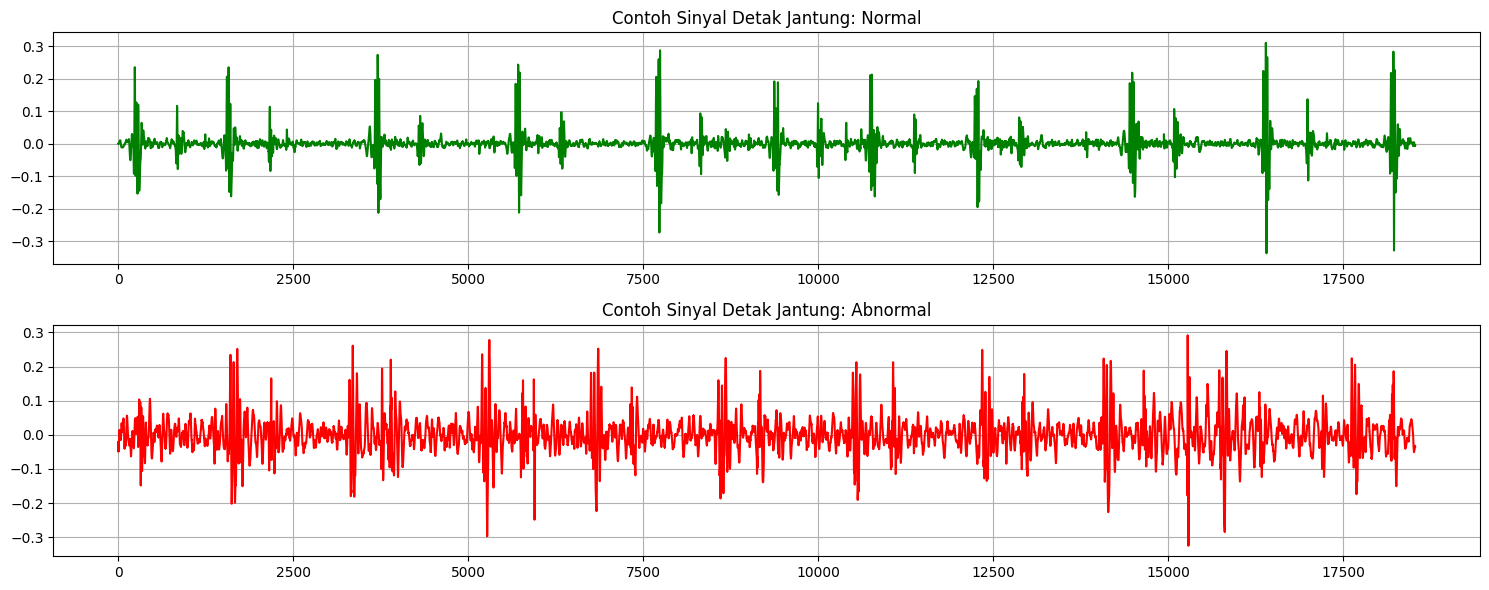

In [29]:
# Fungsi untuk memuat data ARFF ke Pandas DataFrame
def load_arff_data(filename):
    data, meta = arff.loadarff(filename)
    df = pd.DataFrame(data)
    # Decode byte strings ke normal strings jika diperlukan (biasanya kolom target)
    for col in df.select_dtypes([object]):
        df[col] = df[col].str.decode('utf-8')
    return df


# Memuat data Train dan Test
df_train = load_arff_data('./data/BinaryHeartbeat_TRAIN.arff')
df_test = load_arff_data('./data/BinaryHeartbeat_TEST.arff')

print(f"Dimensi Data Train: {df_train.shape}")
print(f"Dimensi Data Test: {df_test.shape}")

# Cek distribusi kelas
target_col = df_train.columns[-1]  # Asumsi kolom terakhir adalah target
print("\nDistribusi Kelas pada Data Train:")
print(df_train[target_col].value_counts())

# Visualisasi Sinyal
plt.figure(figsize=(15, 6))

# Ambil satu contoh Normal dan satu Abnormal
normal_signal = df_train[df_train[target_col] == 'Normal'].iloc[0, :-1].values
abnormal_signal = df_train[df_train[target_col] == 'Abnormal'].iloc[0, :-1].values

# Plot
plt.subplot(2, 1, 1)
plt.plot(normal_signal, color='green')
plt.title("Contoh Sinyal Detak Jantung: Normal")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(abnormal_signal, color='red')
plt.title("Contoh Sinyal Detak Jantung: Abnormal")
plt.grid(True)

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

Data detak jantung memiliki dimensi sangat tinggi (18.530 fitur waktu) dengan jumlah sampel yang sedikit (409 sampel). Preprocessing yang dilakukan:

1. Label Encoding: Mengubah label 'Normal'/'Abnormal' menjadi 0/1.

2. Reshaping: Mengubah bentuk data agar sesuai input model CNN 1D (Samples, Time Steps, Features).

In [ ]:
# 1. Split Features dan Target
X_train_raw = df_train.iloc[:, :-1].values
y_train_raw = df_train.iloc[:, -1].values
X_test_raw = df_test.iloc[:, :-1].values
y_test_raw = df_test.iloc[:, -1].values

# 2. Encoding Label (Normal=0, Abnormal=1)
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

# 3. Standard Scaling (PENTING untuk Neural Network)
# Menyamakan skala sinyal agar model lebih mudah belajar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)


# 4. Reshape ke 3D untuk CNN (Samples, Time Steps, Features)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# 5. Menghitung Class Weights (KUNCI MENINGKATKAN AKURASI)
# Ini akan memberikan bobot lebih besar pada kelas 'Normal' yang jumlahnya sedikit
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

print(f"Class Weights: {class_weights_dict}")

Class Weights: {0: np.float64(0.6845637583892618), 1: np.float64(1.8545454545454545)}


## 4. Modeling (Pemodelan Data)

Kita akan menggunakan 1D-CNN (Convolutional Neural Network). Alasan Pemilihan Model:

- Data berupa Time Series panjang. CNN sangat efisien dalam mengekstrak fitur lokal (pola gelombang) dari data sekuensial panjang tanpa terbebani jumlah parameter yang meledak seperti pada Fully Connected Network.

- Karena datanya sedikit (High Dimensionality, Low Sample Size), kita menggunakan arsitektur sederhana dengan Dropout untuk mencegah overfitting.

### Membangun dan Melatih Model CNN

In [32]:
# Membersihkan sesi lama
tf.keras.backend.clear_session()

model = Sequential()

# --- Block 1 ---
model.add(Conv1D(filters=32, kernel_size=20,
          input_shape=(18530, 1), padding='same'))
model.add(BatchNormalization())  # Menstabilkan training
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.2))

# --- Block 2 ---
model.add(Conv1D(filters=64, kernel_size=10, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.2))

# --- Block 3 ---
model.add(Conv1D(filters=128, kernel_size=10, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# Menggantikan Flatten untuk mengurangi parameter
model.add(GlobalAveragePooling1D())

# --- Dense Layers ---
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))

# Compile dengan Learning Rate yang lebih kecil di awal
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# ReduceLROnPlateau: Turunkan learning rate jika val_loss macet (membantu fine-tuning di epoch akhir)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

# Training dengan Class Weights
history = model.fit(
    X_train_cnn, y_train,
    epochs=50,  # Tambahkan epoch karena ada early stopping
    batch_size=16,
    validation_data=(X_test_cnn, y_test),
    class_weight=class_weights_dict,  # <<< PENTING: Masukkan bobot kelas di sini
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 734ms/step - accuracy: 0.4461 - loss: 0.7671 - val_accuracy: 0.5366 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 694ms/step - accuracy: 0.5196 - loss: 0.7547 - val_accuracy: 0.7220 - val_loss: 0.6383 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 865ms/step - accuracy: 0.6176 - loss: 0.7009 - val_accuracy: 0.7317 - val_loss: 0.6100 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 755ms/step - accuracy: 0.5980 - loss: 0.6601 - val_accuracy: 0.7366 - val_loss: 0.5761 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 710ms/step - accuracy: 0.5882 - loss: 0.6606 - val_accuracy: 0.7317 - val_loss: 0.5598 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 706ms/step - accuracy: 0.6422 - loss: 0.5994 - val_accuracy: 0.7220 - val_loss: 0.5560 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 701ms/step - accuracy: 0.6275 - loss: 0.7265

### Visualisasi Training History

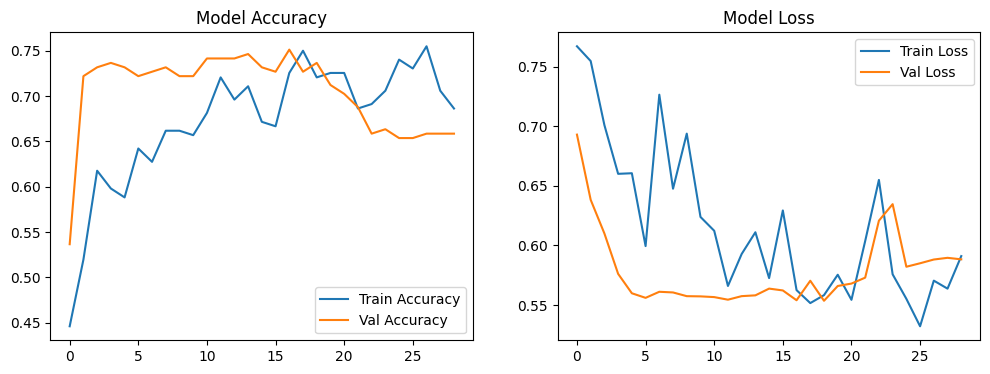

In [33]:
# Plot Accuracy dan Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

## 5. Evaluation (Evaluasi)
Mengevaluasi performa model menggunakan data Test yang belum pernah dilihat model sebelumnya.

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step
Laporan Klasifikasi:
              precision    recall  f1-score   support

    Abnormal       0.77      0.91      0.84       150
      Normal       0.52      0.25      0.34        55

    accuracy                           0.74       205
   macro avg       0.64      0.58      0.59       205
weighted avg       0.70      0.74      0.70       205



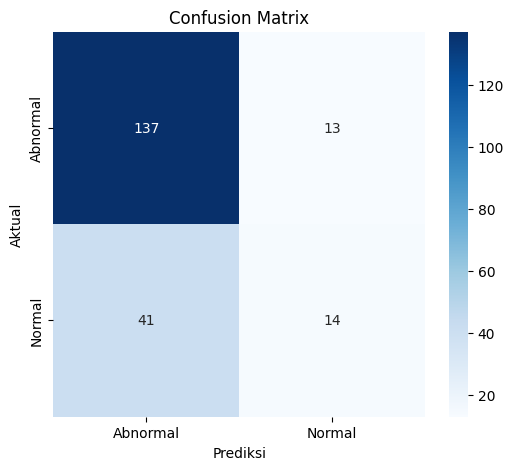

Model berhasil disimpan sebagai 'heartbeat_cnn_model.h5'
Scaler berhasil disimpan sebagai 'scaler.save'


In [37]:
# Prediksi
import joblib
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification Report
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

# Simpan model untuk deployment
model.save('model/heartbeat_cnn_model.h5')
print("Model berhasil disimpan sebagai 'heartbeat_cnn_model.h5'")

# Simpan Scaler agar bisa dipakai di Streamlit
joblib.dump(scaler, 'model/scaler.save')
print("Scaler berhasil disimpan sebagai 'scaler.save'")

### Membuat file untuk test

In [36]:
from scipy.io import arff
import pandas as pd

# Load test data
data_test, meta_test = arff.loadarff('./data/BinaryHeartbeat_TEST.arff')
df_test = pd.DataFrame(data_test)

# Decode 'target' column to string
df_test['target'] = df_test['target'].str.decode('utf-8')

# Save first 5 rows to CSV
df_test.head().to_csv('sample_heartbeat_test.csv', index=False)

print("Sample test data saved to 'sample_heartbeat_test.csv'")
print(df_test.head())

Sample test data saved to 'sample_heartbeat_test.csv'
       att1      att2      att3      att4      att5      att6      att7  \
0 -0.000488 -0.002472 -0.003754 -0.003998 -0.005188 -0.005524 -0.005859   
1  0.013977  0.029633  0.025024  0.023315  0.022430  0.019318  0.015320   
2  0.065521  0.107452  0.055298  0.034119  0.001434 -0.016846 -0.037689   
3 -0.002228 -0.003265 -0.003235 -0.002747 -0.003174 -0.001312 -0.006012   
4 -0.004822 -0.006989 -0.002533  0.001434  0.001160  0.004730  0.002533   

       att8      att9     att10  ...  att18522  att18523  att18524  att18525  \
0 -0.006409 -0.007111 -0.007874  ... -0.006439 -0.007996 -0.008087 -0.009155   
1  0.013672  0.008057  0.009125  ...  0.038666  0.039734  0.040985  0.040131   
2 -0.050598 -0.061523 -0.067261  ...  0.058411  0.053528  0.046143  0.041870   
3 -0.004303 -0.004608 -0.007080  ...  0.013428  0.012604  0.012695  0.013367   
4  0.000977 -0.003174 -0.006256  ...  0.012878  0.012115  0.012451  0.009918   

   att18526  a